# Introduction

The goal of this notebook is testing how long it takes to solve problems with conlloovia depending on the size of the problem. In addition, it compares conlloovia and the heuristic allocators, using two sets of parameters:

- Unrestricted mode: random parameters.
- Restricted mode: parameters constrained to the cases where the first-fit allocator based on size works best.

There are three allocators:

- Conlloovia. The allocator based on the integer linear programming solver.
- First-fit cores descending (FFC).
- First-fit price ascending (FFP).

In [8]:
from pathlib import Path
import random
import dataclasses
from typing import Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns

sns.set_style("whitegrid")
from pulp import PULP_CBC_CMD
from rich.live import Live
from rich.table import Table
from rich import print

from cloudmodel.unified.units import (
    ComputationalUnits,
    CurrencyPerTime,
    Time,
    Requests,
    RequestsPerTime,
    Storage,
)

from conlloovia import (
    Problem,
    App,
    InstanceClass,
    ContainerClass,
    System,
    Workload,
    ConllooviaAllocator,
    Status,
    Solution,
)
from conlloovia.first_fit import (
    FirstFitAllocator2,
    FirstFitIcOrdering,
)

FIG_DIR = Path("figs")

In [3]:
def create_problem(
    n_apps: int, n_ics: int, limit_ics: int, n_ccs: int, limit_ccs: int
) -> Problem:
    """This functions creates a problem with random values. It tries to generate
    a feasible problem, but it's not guaranteed. In addition, it tries to avoid
    unreasonable values, like a container class with more cores than the most
    powerful instance class.

    Args:
        n_apps (int): Number of applications
        n_ics (int): Number of instance classes
        limit_ics (int): Limit of instance classes
        n_ccs (int): Number of container classes per application
        limit_ccs (int): Limit of container classes per application

    Returns:
        Problem: The problem created
    """

    # Create the apps
    apps = tuple(App(name=f"app{a}") for a in range(n_apps))

    # Base price of a core and a gibibyte of memory
    price_core = 0.25
    price_mem_gb = 0.1

    # The maximum number of cores and memory of all the instance classes.
    max_cores = 0
    max_mem_gb = 0

    # Cores and memory of the most powerful machine. The idea is that
    # no container should have more cores and memory than the maximum
    # configuration
    max_conf = (0, 0)

    # Create the instance classes
    ic_list = []
    for i in range(n_ics):
        cores = random.choice([2, 4, 8, 16, 32, 64])

        # Update max_cores
        if cores > max_cores:
            max_cores = cores

        # The memory is proportional to the number of cores
        mem_multiplier = random.choice([4, 8])
        mem_gb = cores * mem_multiplier

        # Update max_mem_gb
        if mem_gb > max_mem_gb:
            max_mem_gb = mem_gb

        # Update max_conf
        if cores >= max_conf[0] and mem_gb > max_conf[1]:
            max_conf = (cores, mem_gb)

        # The price is a random value around the price of the cores and memory
        price = random.gauss(cores * price_core + mem_gb * price_mem_gb, 0.2)

        ic_list.append(
            InstanceClass(
                name=f"ic_{i}",
                price=CurrencyPerTime(f"{price} usd/hour"),
                cores=ComputationalUnits(f"{cores} cores"),
                mem=Storage(f"{mem_gb} gibibytes"),
                limit=limit_ics,
            )
        )
    ics = tuple(ic_list)

    # Set the maximum number of cores and memory of a container class. The max
    # are divided by n_apps to allow to have at least one core per app
    max_cores_per_app = max(1, max_cores // n_apps)  # At least 1
    max_mem_gb_per_app = max(1, max_mem_gb // n_apps)  # At least 1
    max_conf_cores_per_app = max(1, max_conf[0] // n_apps)  # At least 1
    max_conf_mem_gb_per_app = max(1, max_conf[1] // n_apps)  # At least 1

    # Create the container classes
    cc_list = []
    for app in apps:
        for i in range(n_ccs):
            cores = min(
                random.choice([0.25, 0.5, 1, 1.5, 2, 2.5, 4, 8, 16, 32, 64]),
                max_cores_per_app,
                max_conf_cores_per_app,
            )
            mem = min(
                random.choice([0.5, 1, 1.5, 2, 2.5, 4, 8, 16, 32, 64]),
                max_mem_gb_per_app,
                max_conf_mem_gb_per_app,
            )

            cc_list.append(
                ContainerClass(
                    name=f"cc_{app.name}_{i}",
                    cores=ComputationalUnits(f"{cores} cores"),
                    mem=Storage(f"{mem} gibibytes"),
                    app=app,
                    limit=limit_ccs,
                )
            )

    ccs = tuple(cc_list)

    # Generate a random base performance for each app
    perf_base = {}
    for app in apps:
        perf_base[app] = random.randrange(1, 1000)

    # Create the workloads
    workloads = {}
    for app in apps:
        # It starts with 2 because we don't want the maximum value to be 1:
        # randrange(1, 1) would give an error
        max_workload_h = (2 + perf_base[app] * n_ics * limit_ics // n_apps) * 3600
        workloads[app] = Workload(
            num_reqs=Requests(f"{random.randrange(1, max_workload_h)} req"),
            time_slot_size=Time("hour"),
            app=app,
        )

    # Create the performances
    perfs = {}
    for ic in ics:
        for cc in ccs:
            rps = random.gauss(10 * perf_base[cc.app], 0.1) * cc.cores.magnitude
            perfs[(ic, cc)] = RequestsPerTime(f"{rps} req/s")

    system = System(apps=apps, ics=ics, ccs=ccs, perfs=perfs)

    return Problem(system=system, workloads=workloads, sched_time_size=Time("hour"))


def create_restricted_problem(
    n_apps: int, n_ics: int, limit_ics: int, n_ccs: int, limit_ccs: int
) -> Problem:
    """This function creates a problem with a set of restrictions that are the
    basic assumptions followed wheen creating the first fit allocator. They are:

    - The performance of the container classes for an application only depends
      on the number of cores used.

    - All the container classes for an application have a number of cores that
      is multiple of the number of cores of the least powerful container class.

    - The capacity in cores of an instance class is a power of two.

    - The cost of an instance class is proportional to the number of cores.

    - Memory is not an issue. To simulate this, the memory of all container
      classes is set to 0 gibibytes.

    Args:
        n_apps (int): Number of applications
        n_ics (int): Number of instance classes
        limit_ics (int): Limit of instance classes
        n_ccs (int): Number of container classes per application
        limit_ccs (int): Limit of container classes per application

    Returns:
        Problem: The problem created
    """

    # Create the apps
    apps = tuple(App(name=f"app{a}") for a in range(n_apps))

    # Base price of a core
    price_core = 0.25

    max_cores = 0

    ic_list = []
    for i in range(n_ics):
        cores = random.choice([2, 4, 8, 16, 32, 64])
        if cores > max_cores:
            max_cores = cores

        price = cores * price_core
        ic_list.append(
            InstanceClass(
                name=f"ic_{i}",
                price=CurrencyPerTime(f"{price} usd/hour"),
                cores=ComputationalUnits(f"{cores} cores"),
                mem=Storage(f"0 gibibytes"),
                limit=limit_ics,
            )
        )
    ics = tuple(ic_list)

    # The max are divided by n_apps to allow to have at least one core per app
    max_cores_per_app = max(1, max_cores // n_apps)  # At least 1

    cc_list = []
    for app in apps:
        for i in range(n_ccs):
            cores = min(
                random.choice([0.25, 0.5, 1, 1.5, 2, 2.5, 4, 8, 16, 32, 64]),
                max_cores_per_app,
            )

            cc_list.append(
                ContainerClass(
                    name=f"cc_{app.name}_{i}",
                    cores=ComputationalUnits(f"{cores} cores"),
                    mem=Storage(f"0 gibibytes"),
                    app=app,
                    limit=limit_ccs,
                )
            )

    ccs = tuple(cc_list)

    # Generate a random base performance for each app
    perf_base = {}
    for app in apps:
        perf_base[app] = random.randrange(1, 1000)

    # Create the workloads
    workloads = {}
    for app in apps:
        # It starts with 2 because we don't want the maximum value to be 1:
        # randrange(1, 1) would give an error
        max_workload_h = (2 + perf_base[app] * n_ics * limit_ics // n_apps) * 3600
        workloads[app] = Workload(
            num_reqs=Requests(f"{random.randrange(1, max_workload_h)} req"),
            time_slot_size=Time("hour"),
            app=app,
        )

    # Create the performances
    perfs = {}
    for ic in ics:
        for cc in ccs:
            rps = perf_base[cc.app] * cc.cores.to("cores").magnitude
            perfs[(ic, cc)] = RequestsPerTime(f"{rps} req/s")

    system = System(apps=apps, ics=ics, ccs=ccs, perfs=perfs)

    return Problem(system=system, workloads=workloads, sched_time_size=Time("hour"))


def run_exp(
    n_apps,
    n_ics,
    limit_ics,
    n_ccs,
    limit_ccs,
    restricted,
    solver,
    allocator_names,
    allocator_cls,
    allocator_kwargs,
) -> Tuple[Solution, ...]:
    """Solves the problem with the allocators indicated in the allocator_cls and
    returns the solutions. If restricted is True, the problem is created with
    the restrictions of the first fit allocator."""
    if restricted:
        problem = create_restricted_problem(n_apps, n_ics, limit_ics, n_ccs, limit_ccs)
    else:
        problem = create_problem(n_apps, n_ics, limit_ics, n_ccs, limit_ccs)

    sols = {}  # Dictionary with the solutions for each allocator
    for allocator_name, allocator_cl, kwargs in zip(
        allocator_names, allocator_cls, allocator_kwargs
    ):
        alloc = allocator_cl(problem, **kwargs)

        if allocator_name == "conlloovia":
            sol = alloc.solve(solver)
        else:
            sol = alloc.solve()

        sols[allocator_name] = sol

    return sols


def dec2(f: float):
    """Returns a string with two decimals."""
    return f"{f:.2f}"


def run_exp_and_update_stats(
    n_exp,
    n_apps,
    n_ics,
    limit_ics,
    n_ccs,
    limit_ccs,
    restricted,
    solver,
    allocators,
    allocator_cls,
    allocator_kwargs,
    stats,
    sols,
):
    """Runs an experiment and updates the stats dictionary."""

    # Compute the number of variables
    n_vars_x = n_ics * limit_ics
    n_vars_y = n_vars_x * n_apps * n_ccs
    n_vars_total = n_vars_x + n_vars_y

    # Run the experiment until it's feasible
    while True:
        sols_exp = run_exp(
            n_apps,
            n_ics,
            limit_ics,
            n_ccs,
            limit_ccs,
            restricted,
            solver,
            allocators,
            allocator_cls,
            allocator_kwargs,
        )
        if sols_exp["conlloovia"].solving_stats.status != Status.INFEASIBLE:
            break
        print("The experiment was INFEASIBLE. Running again")

    # Save the solutions and the stats
    for allocator, sol in sols_exp.items():
        sols[allocator][n_exp] = sol
        stats[allocator][n_exp] = dataclasses.asdict(sol.solving_stats)
        stats[allocator][n_exp]["num_vars"] = n_vars_total
        stats[allocator][n_exp]["cost"] = sol.cost.to("usd").magnitude

    # For conlloovia, compute the gap percentage if the solution is feasible
    if sols_exp["conlloovia"].solving_stats.status == Status.INTEGER_FEASIBLE:
        bound = stats["conlloovia"][n_exp]["lower_bound"]
        cost_magnitude = sols_exp["conlloovia"].cost.to("usd").magnitude
        stats["conlloovia"][n_exp]["gap_pct"] = (
            100 * (cost_magnitude - bound) / cost_magnitude
        )

        if bound == 0:
            print("Warning: lower bound is 0")

        if stats["conlloovia"][n_exp]["gap_pct"] < 0:
            print("Warning: gap_pct negative (the bound is bigger than the cost)")
    else:
        stats["conlloovia"][n_exp]["gap_pct"] = 0

    # For the other allocators, set the gap percentage to 0
    for allocator in allocators:
        if allocator != "conlloovia":
            stats[allocator][n_exp]["gap_pct"] = 0

    return n_vars_x, n_vars_y, n_vars_total


def run(restricted: bool):
    """Runs the experiments. If restricted is True, the problem is created with
    the restrictions of the first fit allocator."""

    # Set the seed to be able to reproduce the experiments
    random.seed(100)

    # The commented values are alternative values that can be used to run more
    # experiments
    range_apps = [1, 8, 32]  # [1, 2, 4, 8, 16, 32]
    range_ics = [1, 4, 16]  # [1, 2, 4, 8, 16]
    range_limit_ics = [1, 20, 50]  # [1, 10, 20, 50]
    range_ccs = [1, 2, 8]  # [1, 2, 4, 8]

    # Set the limit of container classes to a big number, greater than the
    # maximum number of cores in a instance class (64) divided by the smaller
    # number of cores in a container class (0.5)
    limit_ccs = 64 / 0.5

    # Uncomment the following lines to run a small experiment
    # print("TODO: remove")
    # range_apps = [1, 8]
    # range_ics = [1, 4]
    # range_limit_ics = [1, 20]
    # range_ccs = [1, 2]

    n_exp = 0  # Experiment number
    total_num_exps = (
        len(range_apps) * len(range_ics) * len(range_limit_ics) * len(range_ccs)
    )
    print(f"Num. experiments: {total_num_exps}")

    # Limit to 600 seconds the time of the solver and use 8 threads
    solver = PULP_CBC_CMD(timeLimit=600, threads=8, msg=False)

    allocators = [
        "conlloovia",
        "FFC",
        "FFP",
    ]
    allocator_cls = [
        ConllooviaAllocator,
        FirstFitAllocator2,
        FirstFitAllocator2,
    ]
    allocator_kwargs = [
        {},
        {"ordering": FirstFitIcOrdering.CORE_DESCENDING},
        {"ordering": FirstFitIcOrdering.PRICE_ASCENDING},
    ]

    stats = {i: {} for i in allocators}
    sols = {i: {} for i in allocators}

    # Create a table where each row has a summary of each experiment
    table = Table("Exp", "# vars")
    for allocator in allocators:
        table.add_column(f"{allocator} cost", justify="right")
    table.add_column("Conlloovia status", justify="right")
    table.add_column("Conlloovia sol. time", justify="right")

    # Use a live table to show the progress of the experiments as they run
    with Live(table, auto_refresh=False) as live:
        for n_apps in range_apps:
            for n_ics in range_ics:
                for limit_ics in range_limit_ics:
                    for n_ccs in range_ccs:
                        n_exp += 1

                        n_vars_x, n_vars_y, n_vars_total = run_exp_and_update_stats(
                            n_exp,
                            n_apps,
                            n_ics,
                            limit_ics,
                            n_ccs,
                            limit_ccs,
                            restricted,
                            solver,
                            allocators,
                            allocator_cls,
                            allocator_kwargs,
                            stats,
                            sols,
                        )

                        table_params = []
                        for allocator in allocators:
                            param_cell = dec2(stats[allocator][n_exp]["cost"])

                            if allocator != "conlloovia":
                                diff_conlloovia = (
                                    stats[allocator][n_exp]["cost"]
                                    - stats["conlloovia"][n_exp]["cost"]
                                )
                                param_cell += f" ({diff_conlloovia:.2f})"

                            # Show the lower bound if it's greater than 0,
                            # which can only happen in conlloovia
                            lower_bound = stats[allocator][n_exp]["lower_bound"]
                            if lower_bound and lower_bound > 0:
                                bound = dec2(lower_bound)
                                param_cell += f"/{bound}"

                            table_params.append(param_cell)

                        table_params.append(
                            str(stats["conlloovia"][n_exp]["status"].name)
                        )
                        table_params.append(
                            dec2(stats["conlloovia"][n_exp]["solving_time"])
                        )

                        table.add_row(
                            str(n_exp),
                            str(n_vars_total),
                            *table_params,
                        )
                        live.refresh()

    print(
        f"Biggest experiment -> num X: {n_vars_x:,} num Y: {n_vars_y:,} total: {n_vars_total:,}"
    )
    print(f"num exps: {n_exp}")

    # Printing it again because the Live element doesn't work
    # when the notebook is loaded from disk
    print(table)

    # Save the stats in a CSV file
    file_name = "exp_size_restricted" if restricted else "exp_size_unrestricted"
    save_stats_csv(n_exp, allocators, stats, file_name)

    return sols, stats


def save_stats_csv(
    n_exp: int, allocators: list[str], stats: dict, file_name: str
) -> None:
    """Saves the stats in a CSV file.

    Args:
        n_exp (int): Number of experiments
        allocators (list[str]): List of allocators
        stats (dict): Dictionary with the stats
        file_name (str): Name of the file
    """
    headers = [
        "exp",
        "num_vars",
        *[f"{name} cost" for name in allocators],
        "conlloovia lower_bound",
        "conlloovia gap_pct",
        *[f"{name} status" for name in allocators],
        *[f"{name} creation_time" for name in allocators],
        *[f"{name} solving_time" for name in allocators],
        *[
            f"{name} cost diff conlloovia"
            for name in allocators
            if name != "conlloovia"
        ],
    ]
    df = pd.DataFrame(columns=headers)
    for n_exp in range(1, n_exp + 1):
        row = [n_exp, stats["conlloovia"][n_exp]["num_vars"]]
        for allocator in allocators:
            row.append(stats[allocator][n_exp]["cost"])
        row.append(stats["conlloovia"][n_exp]["lower_bound"])
        row.append(stats["conlloovia"][n_exp]["gap_pct"])
        for allocator in allocators:
            row.append(stats[allocator][n_exp]["status"].name)
        for allocator in allocators:
            row.append(stats[allocator][n_exp]["creation_time"])
        for allocator in allocators:
            row.append(stats[allocator][n_exp]["solving_time"])
        for allocator in allocators:
            if allocator != "conlloovia":
                diff_conlloovia = (
                    stats[allocator][n_exp]["cost"] - stats["conlloovia"][n_exp]["cost"]
                )
                row.append(diff_conlloovia)
        df.loc[n_exp] = row

    df.to_csv(f"{file_name}.csv")


sols = {}
stats = {}

print("Running experiments without restrictions")
sols["unrestricted"], stats["unrestricted"] = run(restricted=False)

print("Running experiments with restrictions")
sols["restricted"], stats["restricted"] = run(restricted=True)


Running experiments without restrictions

Num. experiments: 81

Output()

The experiment was INFEASIBLE. Running again

The experiment was INFEASIBLE. Running again

The experiment was INFEASIBLE. Running again

The experiment was INFEASIBLE. Running again

The experiment was INFEASIBLE. Running again

The experiment was INFEASIBLE. Running again

Biggest experiment -> num X: 800 num Y: 204,800 total: 205,600

num exps: 81

┏━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃     ┃        ┃                 ┃       first fit 2 ┃ first fit 2 (price ┃                   ┃   Conlloovia sol. ┃
┃ Exp ┃ # vars ┃ conlloovia cost ┃ (cores desc) cost ┃          asc) cost ┃ Conlloovia status ┃              time ┃
┡━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 1   │ 2      │            3.87 │       3.87 (0.00) │        3.87 (0.00) │           OPTIMAL │              0.00 │
│ 2   │ 3      │            1.49 │       1.49 (0.00) │        1.49 (0.00) │           OPTIMAL │              0.01 │
│ 3   │ 9      │            8.37 │       8.37 (0.00) │        8.37 (0.00) │           OPTIMAL │              0.01 │
│ 4   │ 40     │            1.23 │       1.23 (0.00) │        1.23 (0.00) │           OPTIMAL │              0.01 │
│ 5   │ 60     │            7.94 │       7.94 (0.00) │        7.94 (0.00) │           OPTIMAL │              0.02 │
│ 6   │ 180    │           67.08 │      67.08 (0.00) │       67.08 (0.00) │           OPTIMAL │              0.02 │
│ 7   │ 100    │           20.77 │      20.77 (0.00) │       20.77 (0.00) │           OPTIMAL │              0.02 │
│ 8   │ 150    │           33.65 │      33.65 (0.00) │       33.65 (0.00) │           OPTIMAL │              0.03 │
│ 9   │ 450    │            2.59 │       2.59 (0.00) │        2.59 (0.00) │           OPTIMAL │              0.08 │
│ 10  │ 8      │            2.05 │       2.05 (0.00) │        2.05 (0.00) │           OPTIMAL │              0.01 │
│ 11  │ 12     │            1.16 │       1.16 (0.00) │        1.68 (0.51) │           OPTIMAL │              0.01 │
│ 12  │ 36     │            1.22 │       1.22 (0.00) │        4.00 (2.78) │           OPTIMAL │              0.01 │
│ 13  │ 160    │           67.44 │      67.44 (0.00) │     141.76 (74.32) │           OPTIMAL │              0.02 │
│ 14  │ 240    │            8.57 │     20.75 (12.18) │      20.75 (12.18) │           OPTIMAL │              0.05 │
│ 15  │ 720    │            5.26 │      10.44 (5.17) │       10.44 (5.17) │           OPTIMAL │              0.10 │
│ 16  │ 400    │   134.14/130.77 │     142.64 (8.49) │     165.65 (31.51) │  INTEGER_FEASIBLE │            600.44 │
│ 17  │ 600    │           10.30 │     20.69 (10.39) │       10.30 (0.00) │           OPTIMAL │              0.28 │
│ 18  │ 1800   │            2.11 │       2.11 (0.00) │        2.11 (0.00) │           OPTIMAL │              0.17 │
│ 19  │ 32     │            4.51 │       4.51 (0.00) │        4.51 (0.00) │           OPTIMAL │              0.02 │
│ 20  │ 48     │           10.25 │      16.48 (6.23) │       18.57 (8.32) │           OPTIMAL │              0.02 │
│ 21  │ 144    │            1.19 │       1.19 (0.00) │        1.77 (0.58) │           OPTIMAL │              0.02 │
│ 22  │ 640    │           14.21 │     33.28 (19.08) │       14.21 (0.00) │           OPTIMAL │              0.26 │
│ 23  │ 960    │            6.58 │      10.32 (3.73) │        6.58 (0.00) │           OPTIMAL │             13.64 │
│ 24  │ 2880   │           18.04 │     33.70 (15.67) │      33.36 (15.32) │           OPTIMAL │            467.43 │
│ 25  │ 1600   │           18.60 │      20.80 (2.19) │    126.09 (107.48) │           OPTIMAL │              2.82 │
│ 26  │ 2400   │           25.05 │     41.87 (16.82) │    148.14 (123.09) │           OPTIMAL │              0.49 │
│ 27  │ 7200   │           12.42 │    100.50 (88.07) │    474.21 (461.79) │           OPTIMAL │             50.97 │
│ 28  │ 9      │           20.89 │      20.89 (0.00) │       20.89 (0.00) │           OPTIMAL │              0.00 │
│ 29  │ 17     │           20.68 │      20.68 (0.00) │       20.68 (0.00) │           OPTIMAL │              0.01 │
│ 30  │ 65     │           33.55 │      33.55 (0.00) │       33.55 (0.00) │           OPTIMAL │              0.12 │
│ 31  │ 180    │            5.14 │       5.14 (0.00) │  

Running experiments with restrictions

Num. experiments: 81

Output()

The experiment was INFEASIBLE. Running again

Biggest experiment -> num X: 800 num Y: 204,800 total: 205,600

num exps: 81

┏━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃     ┃        ┃                 ┃       first fit 2 ┃ first fit 2 (price ┃                   ┃   Conlloovia sol. ┃
┃ Exp ┃ # vars ┃ conlloovia cost ┃ (cores desc) cost ┃          asc) cost ┃ Conlloovia status ┃              time ┃
┡━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 1   │ 2      │            1.00 │       1.00 (0.00) │        1.00 (0.00) │           OPTIMAL │              0.01 │
│ 2   │ 3      │            1.00 │       1.00 (0.00) │        1.00 (0.00) │           OPTIMAL │              0.00 │
│ 3   │ 9      │            0.50 │       0.50 (0.00) │        0.50 (0.00) │           OPTIMAL │              0.01 │
│ 4   │ 40     │            2.00 │       2.00 (0.00) │        2.00 (0.00) │           OPTIMAL │              0.01 │
│ 5   │ 60     │            2.00 │       2.00 (0.00) │        2.00 (0.00) │           OPTIMAL │              0.01 │
│ 6   │ 180    │            6.00 │       6.00 (0.00) │        6.00 (0.00) │           OPTIMAL │              0.01 │
│ 7   │ 100    │           16.00 │      16.00 (0.00) │       16.00 (0.00) │           OPTIMAL │              0.02 │
│ 8   │ 150    │            8.00 │       8.00 (0.00) │        8.00 (0.00) │           OPTIMAL │              0.02 │
│ 9   │ 450    │            9.00 │       9.00 (0.00) │        9.00 (0.00) │           OPTIMAL │              0.03 │
│ 10  │ 8      │            8.00 │       8.00 (0.00) │       17.50 (9.50) │           OPTIMAL │              0.01 │
│ 11  │ 12     │            2.00 │       2.00 (0.00) │        8.00 (6.00) │           OPTIMAL │              0.01 │
│ 12  │ 36     │            2.00 │       2.00 (0.00) │        4.00 (2.00) │           OPTIMAL │              0.01 │
│ 13  │ 160    │           16.00 │      16.00 (0.00) │       16.00 (0.00) │           OPTIMAL │              0.02 │
│ 14  │ 240    │           14.00 │      14.00 (0.00) │       14.00 (0.00) │           OPTIMAL │              0.02 │
│ 15  │ 720    │            8.00 │       8.00 (0.00) │        8.00 (0.00) │           OPTIMAL │              0.04 │
│ 16  │ 400    │           22.00 │      24.00 (2.00) │      33.00 (11.00) │           OPTIMAL │              0.17 │
│ 17  │ 600    │           35.50 │      36.00 (0.50) │       37.00 (1.50) │           OPTIMAL │              0.05 │
│ 18  │ 1800   │            4.00 │       4.00 (0.00) │        4.00 (0.00) │           OPTIMAL │              0.21 │
│ 19  │ 32     │            2.00 │       2.00 (0.00) │        6.00 (4.00) │           OPTIMAL │              0.01 │
│ 20  │ 48     │            1.50 │       2.00 (0.50) │        2.00 (0.50) │           OPTIMAL │              0.01 │
│ 21  │ 144    │            3.50 │       4.00 (0.50) │        3.50 (0.00) │           OPTIMAL │              0.02 │
│ 22  │ 640    │           24.00 │      24.00 (0.00) │    204.00 (180.00) │           OPTIMAL │              0.05 │
│ 23  │ 960    │           73.00 │      80.00 (7.00) │       74.00 (1.00) │           OPTIMAL │              0.08 │
│ 24  │ 2880   │           59.00 │      64.00 (5.00) │       59.00 (0.00) │           OPTIMAL │              0.34 │
│ 25  │ 1600   │          181.00 │     184.00 (3.00) │     231.00 (50.00) │           OPTIMAL │              0.19 │
│ 26  │ 2400   │           24.00 │      32.00 (8.00) │       24.00 (0.00) │           OPTIMAL │              0.19 │
│ 27  │ 7200   │           48.00 │      48.00 (0.00) │       48.00 (0.00) │           OPTIMAL │              0.71 │
│ 28  │ 9      │            4.00 │       4.00 (0.00) │        4.00 (0.00) │           OPTIMAL │              0.00 │
│ 29  │ 17     │           16.00 │      16.00 (0.00) │       16.00 (0.00) │           OPTIMAL │              0.01 │
│ 30  │ 65     │            4.00 │       4.00 (0.00) │        4.00 (0.00) │           OPTIMAL │              0.01 │
│ 31  │ 180    │            4.00 │       4.00 (0.00) │  

In [25]:
# This stores for each mode (restricted or unrestricted) a dictionary where the
# keys are the allocators and the values are dataframes with the stats of each
# experiment
df_stats_dict = {}

# This stores for each mode (restricted or unrestricted) a dataframe with the
# stats of all the experiments for that mode
df_stats_mode = {}
for mode in stats.keys():
    df_stats_dict[mode] = {}
    df_stats_dict[mode] = {
        alloc: pd.DataFrame(stats[mode][alloc]).T.assign(loc=0, alloc=alloc)
        for alloc in stats[mode].keys()
    }
    df_stats_mode[mode] = pd.concat(df_stats_dict[mode].values())
    df_stats_mode[mode] = (
        df_stats_mode[mode].reset_index().rename(columns={"index": "exp"})
    )
    display(df_stats_mode[mode])


,exp,frac_gap,max_seconds,lower_bound,creation_time,solving_time,status,num_vars,cost,gap_pct,loc,alloc
0,1,None,600,None,0.001301,0.004397,Status.OPTIMAL,2,3.870386,0,0,conlloovia
1,2,None,600,None,0.001494,0.006152,Status.OPTIMAL,3,1.493274,0,0,conlloovia
2,3,None,600,None,0.004545,0.006349,Status.OPTIMAL,9,8.373173,0,0,conlloovia
3,4,None,600,None,0.016553,0.008878,Status.OPTIMAL,40,1.229536,0,0,conlloovia
4,5,None,600,None,0.02633,0.016371,Status.OPTIMAL,60,7.937731,0,0,conlloovia
...,...,...,...,...,...,...,...,...,...,...,...,...
238,77,0,0,0,0.006919,0.075516,Status.INTEGER_FEASIBLE,20800,53.284667,0,0,FFP
239,78,0,0,0,0.011647,0.076767,Status.INTEGER_FEASIBLE,82240,50.18195,0,0,FFP
240,79,0,0,0,0.006462,0.266564,Status.INTEGER_FEASIBLE,26400,79.112285,0,0,FFP
241,80,0,0,0,0.006858,0.179585,Status.INTEGER_FEASIBLE,52000,63.900653,0,0,FFP


,exp,frac_gap,max_seconds,lower_bound,creation_time,solving_time,status,num_vars,cost,gap_pct,loc,alloc
0,1,None,600,None,0.000916,0.00596,Status.OPTIMAL,2,1.0,0,0,conlloovia
1,2,None,600,None,0.001401,0.004557,Status.OPTIMAL,3,1.0,0,0,conlloovia
2,3,None,600,None,0.004446,0.005825,Status.OPTIMAL,9,0.5,0,0,conlloovia
3,4,None,600,None,0.016574,0.008954,Status.OPTIMAL,40,2.0,0,0,conlloovia
4,5,None,600,None,0.026598,0.010072,Status.OPTIMAL,60,2.0,0,0,conlloovia
...,...,...,...,...,...,...,...,...,...,...,...,...
238,77,0,0,0,0.006371,0.110867,Status.INTEGER_FEASIBLE,20800,48.0,0,0,FFC
239,78,0,0,0,0.011011,0.242446,Status.INTEGER_FEASIBLE,82240,48.0,0,0,FFC
240,79,0,0,0,0.006528,0.166272,Status.INTEGER_FEASIBLE,26400,114.0,0,0,FFC
241,80,0,0,0,0.006442,0.297809,Status.INTEGER_FEASIBLE,52000,112.0,0,0,FFC


# Time comparison

In [26]:
allocators = [
    "conlloovia",
    "FFC",
    "FFP",
]
modes = ["unrestricted", "restricted"]

In [119]:
# Pass to long form to be able to use seaborn
df_stats_long = {
    mode: df_stats_mode[mode].melt(id_vars=["exp", "num_vars", "status", "alloc"])
    for mode in modes
}

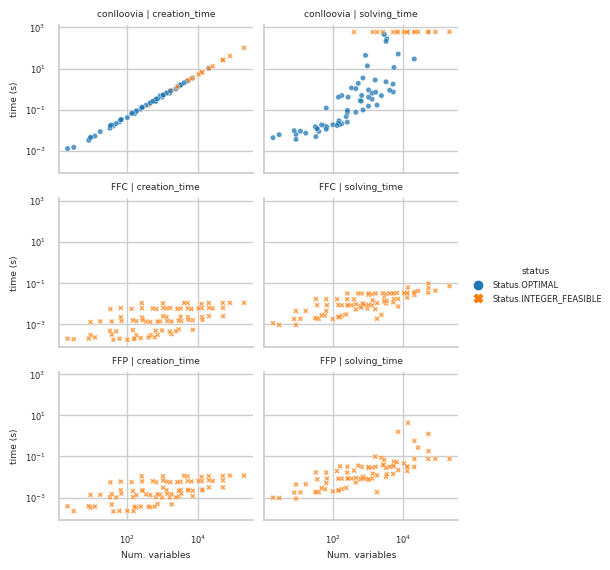

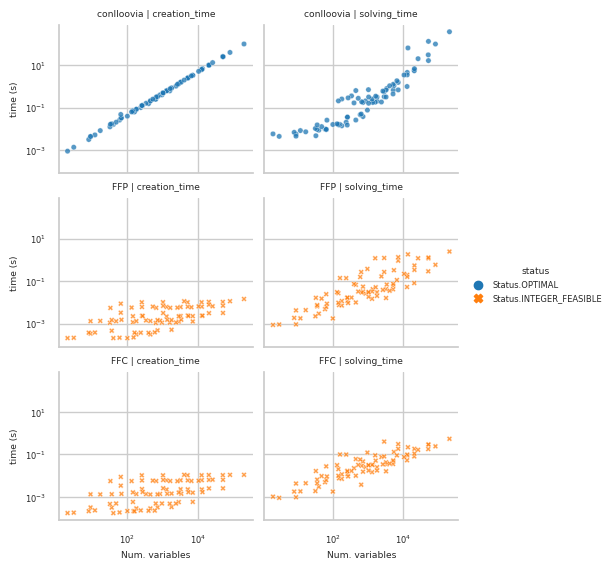

In [49]:
# Both axis using log scales. Notice that negative values not shown

# Plot a scatter plot with the creation and solving times for each mode
with sns.plotting_context("notebook", font_scale=0.55):
    for mode in modes:
        # Select only the rows with the solving and creation times
        df_times = df_stats_long[mode][
            (df_stats_long[mode].variable == "solving_time")
            | (df_stats_long[mode].variable == "creation_time")
        ].rename(columns={"value": "time (s)"})

        g = sns.relplot(
            data=df_times,
            x="num_vars",
            y="time (s)",
            col="variable",
            row="alloc",
            style="status",
            hue="status",
            alpha=0.75,
            height=1.9,
            aspect=1.25,
            s=15,
        )
        g.set(xscale="log")
        g.set(yscale="log")
        g.set_titles(template="{row_name} | {col_name}")
        g.fig.subplots_adjust(top=0.95)
        g.set(xlabel='Num. variables')
               
        filename = "time_unrestr.png" if mode == "unrestricted" else "time_restr.png"
        g.fig.savefig(FIG_DIR/filename, bbox_inches='tight', dpi=600)

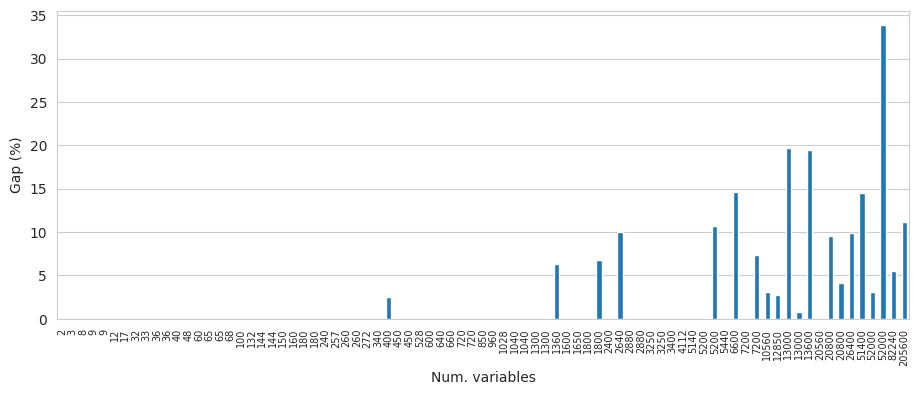

In [164]:
# Plot frac gap for conlloovia
for mode in modes:
    conlloovia_data = df_stats_dict[mode]["conlloovia"]
    if Status.INTEGER_FEASIBLE in set(conlloovia_data.status):
        fig, ax = plt.subplots(figsize=(11, 4))
        ax = conlloovia_data.sort_values(by="num_vars").plot(
            x="num_vars", y="gap_pct", kind="bar", legend=False, ax=ax
        )
        ax.set_ylabel("Gap (%)")
        ax.tick_params(
            axis="x", labelsize=7
        )  # setting the font size of x-tick labels
        _ = ax.set_xlabel("Num. variables")
        _ = plt.grid(axis="x")
        
        plt.savefig(FIG_DIR/"gap.png", bbox_inches='tight', dpi=600)

In [163]:
df_stats_dict["unrestricted"]["conlloovia"].gap_pct.max()

33.82120069157256

# Cost comparison

In [144]:
# Have the value of each column for the two allocators
df_stats_gr = {}
for mode in modes:
    df_stats_gr[mode] = df_stats_mode[mode].pivot(index=["exp", "num_vars"], columns=["alloc"])

In [145]:
# Print the number of experiments with each status for each allocator
for mode in modes:
    print(f"Status for the {mode} experiments")
    print(df_stats_gr[mode].status.apply(pd.value_counts).fillna(0))


Status for the unrestricted experiments

alloc                     FFC   FFP  conlloovia
Status.INTEGER_FEASIBLE  81.0  81.0          20
Status.OPTIMAL            0.0   0.0          61

Status for the restricted experiments

alloc                     FFC   FFP  conlloovia
Status.INTEGER_FEASIBLE  81.0  81.0         0.0
Status.OPTIMAL            0.0   0.0        81.0

In [146]:
df_stats_gr[mode]

frac_gap                max_seconds                lower_bound  \
alloc             FFC FFP conlloovia         FFC FFP conlloovia         FFC   
exp num_vars                                                                  
1   2               0   0       None           0   0        600           0   
2   3               0   0       None           0   0        600           0   
3   9               0   0       None           0   0        600           0   
4   40              0   0       None           0   0        600           0   
5   60              0   0       None           0   0        600           0   
...               ...  ..        ...         ...  ..        ...         ...   
77  20800           0   0       None           0   0        600           0   
78  82240           0   0       None           0   0        600           0   
79  26400           0   0       None           0   0        600           0   
80  52000           0   0       None           0   0        600           0   
81  205600          0   0       None           0   0        600           0   

                            creation_time  ...          status   cost         \
alloc        FFP conlloovia           FFC  ...      conlloovia    FFC    FFP   
exp num_vars                               ...                                 
1   2          0       None      0.000175  ...  Status.OPTIMAL    1.0    1.0   
2   3          0       None      0.000183  ...  Status.OPTIMAL    1.0    1.0   
3   9          0       None      0.000321  ...  Status.OPTIMAL    0.5    0.5   
4   40         0       None      0.000174  ...  Status.OPTIMAL    2.0    2.0   
5   60         0       None      0.000187  ...  Status.OPTIMAL    2.0    2.0   
...           ..        ...           ...  ...             ...    ...    ...   
77  20800      0       None      0.006371  ...  Status.OPTIMAL   48.0   43.0   
78  82240      0       None      0.011011  ...  Status.OPTIMAL   48.0   42.0   
79  26400      0       None      0.006528  ...  Status.OPTIMAL  114.0  114.0   
80  52000      0       None      0.006442  ...  Status.OPTIMAL  112.0  110.0   
81  205600     0       None      0.011078  ...  Status.OPTIMAL   96.0   91.0   

                        gap_pct                loc                 
alloc        conlloovia     FFC FFP conlloovia FFC FFP conlloovia  
exp num_vars                                                       
1   2               1.0       0   0          0   0   0          0  
2   3               1.0       0   0          0   0   0          0  
3   9               0.5       0   0          0   0   0          0  
4   40              2.0       0   0          0   0   0          0  
5   60              2.0       0   0          0   0   0          0  
...                 ...     ...  ..        ...  ..  ..        ...  
77  20800          42.5       0   0          0   0   0          0  
78  82240          41.5       0   0          0   0   0          0  
79  26400         113.5       0   0          0   0   0          0  
80  52000         109.0       0   0          0   0   0          0  
81  205600         90.0       0   0          0   0   0          0  

[81 rows x 27 columns]

unrestricted             num_vars        FFC %        FFP %
count      81.000000    81.000000    81.000000
mean     8467.407407    80.614111   193.555360
std     26082.483239   182.128561   627.230288
min         2.000000     0.000000     0.000000
25%       144.000000     0.000000     0.000000
50%       850.000000     0.000000    16.852763
75%      5140.000000    84.821308    84.967625
max    205600.000000  1113.116092  3716.773618

restricted             num_vars      FFC %       FFP %
count      81.000000  81.000000   81.000000
mean     8467.407407   7.187012   34.845184
std     26082.483239  14.934361   99.324638
min         2.000000   0.000000    0.000000
25%       144.000000   0.000000    0.000000
50%       850.000000   0.000000    0.000000
75%      5140.000000   6.666667   25.000000
max    205600.000000  60.000000  750.000000

<Figure size 640x480 with 0 Axes>

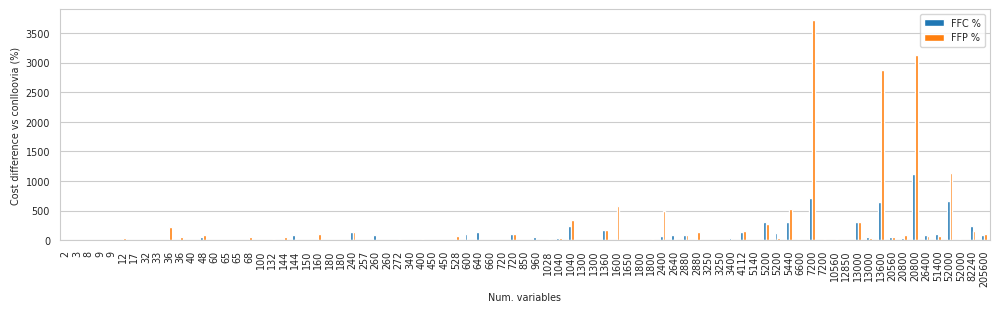

<Figure size 640x480 with 0 Axes>

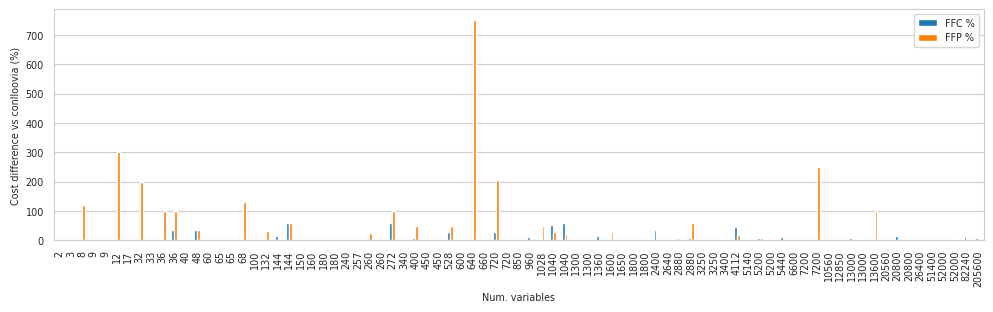

In [158]:
# Plot the difference with conlloovia of all allocators, both in absolute and
# percentage terms. Show the difference only in the experiments where the
# heuristic finds a solution
for mode in modes:
    df_cost_diff = df_stats_gr[mode].reset_index()[["num_vars", "cost"]].copy()
    df_cost_diff.columns = ["num_vars", "FFC", "FFP", "conlloovia"]
    
    for allocator in allocators:
        if allocator == "conlloovia":
            continue

        # Compute the data (pct_change and diff)
        df_cost_diff[f"{allocator} %"] = (
            df_cost_diff[["conlloovia", allocator]].pct_change(axis=1)[allocator] * 100
        )
        df_cost_diff[f"diff_{allocator}"] = df_cost_diff[allocator] - df_cost_diff["conlloovia"]

    print(mode, df_cost_diff.describe())
        
    # Plot the percentage change
    fig = plt.figure()
    ax = df_cost_diff[["num_vars", "FFC %", "FFP %"]].sort_values(by="num_vars").plot(
        x="num_vars", kind="bar", figsize=(12, 3))
    plt.grid(axis="x")
    plt.xlabel('Num. variables', fontsize="x-small")
    plt.ylabel('Cost difference vs conlloovia (%)', fontsize="x-small")
    ax.xaxis.set_tick_params(labelsize="x-small")
    ax.yaxis.set_tick_params(labelsize="x-small")
    plt.legend(fontsize="x-small")

    file_name = "cost_unrestr" if mode == "unrestricted" else "cost_restr"
    plt.savefig(FIG_DIR/file_name, bbox_inches='tight', dpi=600)

# Analysis of the maximum difference between conlloovia and first fit 2 cores desc

## Unrestricted

In [111]:
from conlloovia.visualization import ProblemPrettyPrinter, SolutionPrettyPrinter

# Put in df_cost_diff the difference between the cost of conlloovia and first fit 2 cores desc
mode = "unrestricted"
allocator = "FFC"
df_cost_diff = df_stats_gr[mode][
    df_stats_gr[mode].status[allocator] == Status.INTEGER_FEASIBLE
].cost.copy()
df_cost_diff["pct_change"] = (
    df_cost_diff[["conlloovia", allocator]].pct_change(axis=1)[allocator] * 100
)
df_cost_diff["diff"] = df_cost_diff[allocator] - df_cost_diff.conlloovia


# Find the experiment number with the biggest difference in percentage
max_diff_exp = df_cost_diff.sort_values(by="pct_change", ascending=False).head(1)
display(max_diff_exp)
max_diff_exp_num = max_diff_exp.index[0]


alloc,FFC,FFP,conlloovia,pct_change,diff
exp,,,,,
51,168.588131,448.862524,13.897114,1113.116092,154.691017


In [129]:
from conlloovia.visualization import ProblemPrettyPrinter, SolutionPrettyPrinter

# Print the problem
ProblemPrettyPrinter(sols[mode]["conlloovia"][max_diff_exp_num].problem).print()

# Save and print the solutions
for allocator in ["conlloovia", "FFC"]:
    allocator_name = allocator.replace(" ", "_")
    with open(f"sols_exp_{max_diff_exp_num}_{allocator_name}.p", "wb") as f:
        sol = sols[mode][allocator][max_diff_exp_num]
        # pickle.dump(sol, f)
        print(f"Solution for {allocator}")
        SolutionPrettyPrinter(sol).print()


                         Instance classes                          
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Instance class ┃   Cores ┃        Mem ┃           Price ┃ Limit ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ ic_0           │  2 core │ 0 gibibyte │  0.5 usd / hour │     1 │
│ ic_1           │ 16 core │ 0 gibibyte │  4.0 usd / hour │     1 │
│ ic_2           │  2 core │ 0 gibibyte │  0.5 usd / hour │     1 │
│ ic_3           │  2 core │ 0 gibibyte │  0.5 usd / hour │     1 │
│ ic_4           │ 32 core │ 0 gibibyte │  8.0 usd / hour │     1 │
│ ic_5           │ 16 core │ 0 gibibyte │  4.0 usd / hour │     1 │
│ ic_6           │ 16 core │ 0 gibibyte │  4.0 usd / hour │     1 │
│ ic_7           │ 32 core │ 0 gibibyte │  8.0 usd / hour │     1 │
│ ic_8           │ 64 core │ 0 gibibyte │ 16.0 usd / hour │     1 │
│ ic_9           │  4 core │ 0 gibibyte │  1.0 usd / hour │     1 │
│ ic_10          │ 16 core │ 0 gibibyte │  4.0 usd / hour │     1 │
│ ic_11          │  2 core │ 0 gibibyte │  0.5 usd / hour │     1 │
│ ic_12          │  4 core │ 0 gibibyte │  1.0 usd / hour │     1 │
│ ic_13          │  4 core │ 0 gibibyte │  1.0 usd / hour │     1 │
│ ic_14          │ 32 core │ 0 gibibyte │  8.0 usd / hour │     1 │
│ ic_15          │  4 core │ 0 gibibyte │  1.0 usd / hour │     1 │
└────────────────┴─────────┴────────────┴─────────────────┴───────┘

                 Container classes                 
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Container class ┃    Cores ┃        Mem ┃ Limit ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ cc_app0_0       │ 1.5 core │ 0 gibibyte │ 128.0 │
│ cc_app0_1       │   2 core │ 0 gibibyte │ 128.0 │
│ cc_app1_0       │   1 core │ 0 gibibyte │ 128.0 │
│ cc_app1_1       │ 0.5 core │ 0 gibibyte │ 128.0 │
│ cc_app2_0       │ 0.5 core │ 0 gibibyte │ 128.0 │
│ cc_app2_1       │   8 core │ 0 gibibyte │ 128.0 │
│ cc_app3_0       │ 2.5 core │ 0 gibibyte │ 128.0 │
│ cc_app3_1       │   8 core │ 0 gibibyte │ 128.0 │
│ cc_app4_0       │   4 core │ 0 gibibyte │ 128.0 │
│ cc_app4_1       │ 2.5 core │ 0 gibibyte │ 128.0 │
│ cc_app5_0       │   8 core │ 0 gibibyte │ 128.0 │
│ cc_app5_1       │ 1.5 core │ 0 gibibyte │ 128.0 │
│ cc_app6_0       │   8 core │ 0 gibibyte │ 128.0 │
│ cc_app6_1       │   8 core │ 0 gibibyte │ 128.0 │
│ cc_app7_0       │ 1.5 core │ 0 gibibyte │ 128.0 │
│ cc_app7_1       │   4 core │ 0 gibibyte │ 128.0 │
└─────────────────┴──────────┴────────────┴───────┘

             Apps              
┏━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Name ┃             Workload ┃
┡━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ app0 │ 3554410.0 req / hour │
│ app1 │ 2738843.0 req / hour │
│ app2 │  949007.0 req / hour │
│ app3 │   53194.0 req / hour │
│ app4 │ 2918519.0 req / hour │
│ app5 │ 2227403.0 req / hour │
│ app6 │ 6105170.0 req / hour │
│ app7 │ 1385186.0 req / hour │
└──────┴──────────────────────┘

                                Performances                                 
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Instance class ┃ Container class ┃ App  ┃    RPS ┃ Price per million req. ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ ic_0           │ cc_app0_0       │ app0 │ 1012.5 │                   0.14 │
│                │ cc_app0_1       │ app0 │ 1350.0 │                   0.10 │
│                │ cc_app1_0       │ app1 │  802.0 │                   0.17 │
│                │ cc_app1_1       │ app1 │  401.0 │                   0.35 │
│                │ cc_app2_0       │ app2 │  198.0 │                   0.70 │
│                │ cc_app2_1       │ app2 │ 3168.0 │                   0.04 │
│                │ cc_app3_0       │ app3 │  232.5 │                   0.60 │
│                │ cc_app3_1       │ app3 │  744.0 │                   0.19 │
│                │ cc_app4_0       │ app4 │ 2992.0 │                   0.05 │
│                │ cc_app4_1       │ app4 │ 1870.0 │                   0.07 │
│                │ cc_app5_0       │ app5 │ 4112.0 │                   0.03 │
│                │ cc_app5_1       │ app5 │  771.0 │                   0.18 │
│                │ cc_app6_0       │ app6 │ 7224.0 │                   0.02 │
│                │ cc_app6_1       │ app6 │ 7224.0 │                   0.02 │
│                │ cc_app7_0       │ app7 │ 1053.0 │                   0.13 │
│                │ cc_app7_1       │ app7 │ 2808.0 │                   0.05 │
├────────────────┼─────────────────┼──────┼────────┼────────────────────────┤
│ ic_1           │ cc_app0_0       │ app0 │ 1012.5 │                   1.10 │
│                │ cc_app0_1       │ app0 │ 1350.0 │                   0.82 │
│                │ cc_app1_0       │ app1 │  802.0 │                   1.39 │
│                │ cc_app1_1       │ app1 │  401.0 │                   2.77 │
│                │ cc_app2_0       │ app2 │  198.0 │                   5.61 │
│                │ cc_app2_1       │ app2 │ 3168.0 │                   0.35 │
│                │ cc_app3_0       │ app3 │  232.5 │                   4.78 │
│                │ cc_app3_1       │ app3 │  744.0 │                   1.49 │
│                │ cc_app4_0       │ app4 │ 2992.0 │                   0.37 │
│                │ cc_app4_1       │ app4 │ 1870.0 │                   0.59 │
│                │ cc_app5_0       │ app5 │ 4112.0 │                   0.27 │
│                │ cc_app5_1       │ app5 │  771.0 │                   1.44 │
│                │ cc_app6_0       │ app6 │ 7224.0 │                   0.15 │
│                │ cc_app6_1       │ app6 │ 7224.0 │                   0.15 │
│                │ cc_app7_0       │ app7 │ 1053.0 │                   1.06 │
│                │ cc_app7_1       │ app7 │ 2808.0 │                   0.40 │
├────────────────┼─────────────────┼──────┼────────┼────────────────────────┤
│ ic_2           │ cc_app0_0       │ app0 │ 1012.5 │                   0.14 │
│                │ cc_app0_1       │ app0 │ 1350.0 │                   0.10 │
│                │ cc_app1_0       │ app1 │  802.0 │                   0.17 │
│                │ cc_app1_1       │ app1 │  401.0 │                   0.35 │
│                │ cc_app2_0       │ app2 │  198.0 │                   0.70 │
│                │ cc_app2_1       │ app2 │ 3168.0 │                   0.04 │
│                │ cc_app3_0       │ app3 │  232.5 │                   0.60 │
│                │ cc_app3_1       │ app3 │  744.0 │                   0.19 │
│                │ cc_app4_0       │ app4 │ 2992.0 │                   0.05 │
│                │ cc_app4_1       │ app4 │ 1870.0 │                   0.07 │
│                │ cc_app5_0       │ app5 │ 4112.0 │                   0.03 │
│                │ cc_app5_1       │ app5 │  771.0 │                   0.18 │
│                │ cc_app6_0       │ app6 │ 7224.0 │                   0.02 │
│                │ cc_

Solution for conlloovia

 VM allocation (only  
      used VMs)       
┏━━━━━━━━━━┳━━━━━━━━━┓
┃ VM       ┃    Cost ┃
┡━━━━━━━━━━╇━━━━━━━━━┩
│ ic_1[0]  │ 4.0 usd │
│ ic_3[0]  │ 0.5 usd │
│ ic_11[0] │ 0.5 usd │
├──────────┼─────────┤
│ total: 3 │ 5.0 usd │
└──────────┴─────────┘

           Container allocation (only used VMs)           
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ VM       ┃ Container      ┃ App  ┃                Perf ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ ic_1[0]  │ cc_app3_0 (x1) │ app3 │   837000.0 req (x1) │
│          │ cc_app4_1 (x1) │ app4 │  6732000.0 req (x1) │
│          │ cc_app5_1 (x1) │ app5 │  2775600.0 req (x1) │
│          │ cc_app6_0 (x1) │ app6 │ 26006400.0 req (x1) │
│          │ cc_app7_0 (x1) │ app7 │  3790800.0 req (x1) │
├──────────┼────────────────┼──────┼─────────────────────┤
│ ic_3[0]  │ cc_app1_1 (x2) │ app1 │  1443600.0 req (x2) │
│          │ cc_app2_0 (x2) │ app2 │   712800.0 req (x2) │
├──────────┼────────────────┼──────┼─────────────────────┤
│ ic_11[0] │ cc_app0_0 (x1) │ app0 │  3645000.0 req (x1) │
├──────────┼────────────────┼──────┼─────────────────────┤
│ total: 3 │ 10             │      │      48099600.0 req │
└──────────┴────────────────┴──────┴─────────────────────┘

Total cost: 5.0 usd

KeyError: 'FFC'

## Restricted

In [125]:
# Put in df_cost_diff the difference between the cost of conlloovia and first fit 2 cores desc
mode = "restricted"
allocator = "FFC"
df_cost_diff = df_stats_gr[mode][
    df_stats_gr[mode].status[allocator] == Status.INTEGER_FEASIBLE
].cost.copy()
df_cost_diff["pct_change"] = (
    df_cost_diff[["conlloovia", allocator]].pct_change(axis=1)[allocator] * 100
)
df_cost_diff["diff"] = df_cost_diff[allocator] - df_cost_diff.conlloovia


# Find the experiment number with the biggest difference in percentage
max_diff_exp = df_cost_diff.sort_values(by="pct_change", ascending=False).head(1)
display(max_diff_exp)
max_diff_exp_num = max_diff_exp.index[0]


alloc,FFC,FFP,conlloovia,pct_change,diff
exp,,,,,
47,8.0,10.0,5.0,60.0,3.0


In [130]:
from conlloovia.visualization import ProblemPrettyPrinter, SolutionPrettyPrinter

# Print the problem
ProblemPrettyPrinter(sols[mode]["conlloovia"][max_diff_exp_num].problem).print()

# Save and print the solutions
for allocator in ["conlloovia", "first fit 2 (cores desc)"]:
    allocator_name = allocator.replace(" ", "_")
    with open(f"sols_exp_{max_diff_exp_num}_{allocator_name}.p", "wb") as f:
        sol = sols[mode][allocator][max_diff_exp_num]
        # pickle.dump(sol, f)
        print(f"Solution for {allocator}")
        SolutionPrettyPrinter(sol).print()


                         Instance classes                          
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Instance class ┃   Cores ┃        Mem ┃           Price ┃ Limit ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ ic_0           │  2 core │ 0 gibibyte │  0.5 usd / hour │     1 │
│ ic_1           │ 16 core │ 0 gibibyte │  4.0 usd / hour │     1 │
│ ic_2           │  2 core │ 0 gibibyte │  0.5 usd / hour │     1 │
│ ic_3           │  2 core │ 0 gibibyte │  0.5 usd / hour │     1 │
│ ic_4           │ 32 core │ 0 gibibyte │  8.0 usd / hour │     1 │
│ ic_5           │ 16 core │ 0 gibibyte │  4.0 usd / hour │     1 │
│ ic_6           │ 16 core │ 0 gibibyte │  4.0 usd / hour │     1 │
│ ic_7           │ 32 core │ 0 gibibyte │  8.0 usd / hour │     1 │
│ ic_8           │ 64 core │ 0 gibibyte │ 16.0 usd / hour │     1 │
│ ic_9           │  4 core │ 0 gibibyte │  1.0 usd / hour │     1 │
│ ic_10          │ 16 core │ 0 gibibyte │  4.0 usd / hour │     1 │
│ ic_11          │  2 core │ 0 gibibyte │  0.5 usd / hour │     1 │
│ ic_12          │  4 core │ 0 gibibyte │  1.0 usd / hour │     1 │
│ ic_13          │  4 core │ 0 gibibyte │  1.0 usd / hour │     1 │
│ ic_14          │ 32 core │ 0 gibibyte │  8.0 usd / hour │     1 │
│ ic_15          │  4 core │ 0 gibibyte │  1.0 usd / hour │     1 │
└────────────────┴─────────┴────────────┴─────────────────┴───────┘

                 Container classes                 
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Container class ┃    Cores ┃        Mem ┃ Limit ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ cc_app0_0       │ 1.5 core │ 0 gibibyte │ 128.0 │
│ cc_app0_1       │   2 core │ 0 gibibyte │ 128.0 │
│ cc_app1_0       │   1 core │ 0 gibibyte │ 128.0 │
│ cc_app1_1       │ 0.5 core │ 0 gibibyte │ 128.0 │
│ cc_app2_0       │ 0.5 core │ 0 gibibyte │ 128.0 │
│ cc_app2_1       │   8 core │ 0 gibibyte │ 128.0 │
│ cc_app3_0       │ 2.5 core │ 0 gibibyte │ 128.0 │
│ cc_app3_1       │   8 core │ 0 gibibyte │ 128.0 │
│ cc_app4_0       │   4 core │ 0 gibibyte │ 128.0 │
│ cc_app4_1       │ 2.5 core │ 0 gibibyte │ 128.0 │
│ cc_app5_0       │   8 core │ 0 gibibyte │ 128.0 │
│ cc_app5_1       │ 1.5 core │ 0 gibibyte │ 128.0 │
│ cc_app6_0       │   8 core │ 0 gibibyte │ 128.0 │
│ cc_app6_1       │   8 core │ 0 gibibyte │ 128.0 │
│ cc_app7_0       │ 1.5 core │ 0 gibibyte │ 128.0 │
│ cc_app7_1       │   4 core │ 0 gibibyte │ 128.0 │
└─────────────────┴──────────┴────────────┴───────┘

             Apps              
┏━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Name ┃             Workload ┃
┡━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ app0 │ 3554410.0 req / hour │
│ app1 │ 2738843.0 req / hour │
│ app2 │  949007.0 req / hour │
│ app3 │   53194.0 req / hour │
│ app4 │ 2918519.0 req / hour │
│ app5 │ 2227403.0 req / hour │
│ app6 │ 6105170.0 req / hour │
│ app7 │ 1385186.0 req / hour │
└──────┴──────────────────────┘

                                Performances                                 
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Instance class ┃ Container class ┃ App  ┃    RPS ┃ Price per million req. ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ ic_0           │ cc_app0_0       │ app0 │ 1012.5 │                   0.14 │
│                │ cc_app0_1       │ app0 │ 1350.0 │                   0.10 │
│                │ cc_app1_0       │ app1 │  802.0 │                   0.17 │
│                │ cc_app1_1       │ app1 │  401.0 │                   0.35 │
│                │ cc_app2_0       │ app2 │  198.0 │                   0.70 │
│                │ cc_app2_1       │ app2 │ 3168.0 │                   0.04 │
│                │ cc_app3_0       │ app3 │  232.5 │                   0.60 │
│                │ cc_app3_1       │ app3 │  744.0 │                   0.19 │
│                │ cc_app4_0       │ app4 │ 2992.0 │                   0.05 │
│                │ cc_app4_1       │ app4 │ 1870.0 │                   0.07 │
│                │ cc_app5_0       │ app5 │ 4112.0 │                   0.03 │
│                │ cc_app5_1       │ app5 │  771.0 │                   0.18 │
│                │ cc_app6_0       │ app6 │ 7224.0 │                   0.02 │
│                │ cc_app6_1       │ app6 │ 7224.0 │                   0.02 │
│                │ cc_app7_0       │ app7 │ 1053.0 │                   0.13 │
│                │ cc_app7_1       │ app7 │ 2808.0 │                   0.05 │
├────────────────┼─────────────────┼──────┼────────┼────────────────────────┤
│ ic_1           │ cc_app0_0       │ app0 │ 1012.5 │                   1.10 │
│                │ cc_app0_1       │ app0 │ 1350.0 │                   0.82 │
│                │ cc_app1_0       │ app1 │  802.0 │                   1.39 │
│                │ cc_app1_1       │ app1 │  401.0 │                   2.77 │
│                │ cc_app2_0       │ app2 │  198.0 │                   5.61 │
│                │ cc_app2_1       │ app2 │ 3168.0 │                   0.35 │
│                │ cc_app3_0       │ app3 │  232.5 │                   4.78 │
│                │ cc_app3_1       │ app3 │  744.0 │                   1.49 │
│                │ cc_app4_0       │ app4 │ 2992.0 │                   0.37 │
│                │ cc_app4_1       │ app4 │ 1870.0 │                   0.59 │
│                │ cc_app5_0       │ app5 │ 4112.0 │                   0.27 │
│                │ cc_app5_1       │ app5 │  771.0 │                   1.44 │
│                │ cc_app6_0       │ app6 │ 7224.0 │                   0.15 │
│                │ cc_app6_1       │ app6 │ 7224.0 │                   0.15 │
│                │ cc_app7_0       │ app7 │ 1053.0 │                   1.06 │
│                │ cc_app7_1       │ app7 │ 2808.0 │                   0.40 │
├────────────────┼─────────────────┼──────┼────────┼────────────────────────┤
│ ic_2           │ cc_app0_0       │ app0 │ 1012.5 │                   0.14 │
│                │ cc_app0_1       │ app0 │ 1350.0 │                   0.10 │
│                │ cc_app1_0       │ app1 │  802.0 │                   0.17 │
│                │ cc_app1_1       │ app1 │  401.0 │                   0.35 │
│                │ cc_app2_0       │ app2 │  198.0 │                   0.70 │
│                │ cc_app2_1       │ app2 │ 3168.0 │                   0.04 │
│                │ cc_app3_0       │ app3 │  232.5 │                   0.60 │
│                │ cc_app3_1       │ app3 │  744.0 │                   0.19 │
│                │ cc_app4_0       │ app4 │ 2992.0 │                   0.05 │
│                │ cc_app4_1       │ app4 │ 1870.0 │                   0.07 │
│                │ cc_app5_0       │ app5 │ 4112.0 │                   0.03 │
│                │ cc_app5_1       │ app5 │  771.0 │                   0.18 │
│                │ cc_app6_0       │ app6 │ 7224.0 │                   0.02 │
│                │ cc_

Solution for conlloovia

 VM allocation (only  
      used VMs)       
┏━━━━━━━━━━┳━━━━━━━━━┓
┃ VM       ┃    Cost ┃
┡━━━━━━━━━━╇━━━━━━━━━┩
│ ic_1[0]  │ 4.0 usd │
│ ic_3[0]  │ 0.5 usd │
│ ic_11[0] │ 0.5 usd │
├──────────┼─────────┤
│ total: 3 │ 5.0 usd │
└──────────┴─────────┘

           Container allocation (only used VMs)           
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ VM       ┃ Container      ┃ App  ┃                Perf ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ ic_1[0]  │ cc_app3_0 (x1) │ app3 │   837000.0 req (x1) │
│          │ cc_app4_1 (x1) │ app4 │  6732000.0 req (x1) │
│          │ cc_app5_1 (x1) │ app5 │  2775600.0 req (x1) │
│          │ cc_app6_0 (x1) │ app6 │ 26006400.0 req (x1) │
│          │ cc_app7_0 (x1) │ app7 │  3790800.0 req (x1) │
├──────────┼────────────────┼──────┼─────────────────────┤
│ ic_3[0]  │ cc_app1_1 (x2) │ app1 │  1443600.0 req (x2) │
│          │ cc_app2_0 (x2) │ app2 │   712800.0 req (x2) │
├──────────┼────────────────┼──────┼─────────────────────┤
│ ic_11[0] │ cc_app0_0 (x1) │ app0 │  3645000.0 req (x1) │
├──────────┼────────────────┼──────┼─────────────────────┤
│ total: 3 │ 10             │      │      48099600.0 req │
└──────────┴────────────────┴──────┴─────────────────────┘

Total cost: 5.0 usd

Solution for first fit 2 (cores desc)

 VM allocation (only  
      used VMs)       
┏━━━━━━━━━━┳━━━━━━━━━┓
┃ VM       ┃    Cost ┃
┡━━━━━━━━━━╇━━━━━━━━━┩
│ ic_4[1]  │ 8.0 usd │
├──────────┼─────────┤
│ total: 1 │ 8.0 usd │
└──────────┴─────────┘

           Container allocation (only used VMs)           
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ VM       ┃ Container      ┃ App  ┃                Perf ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ ic_4[1]  │ cc_app6_0 (x1) │ app6 │ 26006400.0 req (x1) │
│          │ cc_app3_0 (x1) │ app3 │   837000.0 req (x1) │
│          │ cc_app4_1 (x1) │ app4 │  6732000.0 req (x1) │
│          │ cc_app0_0 (x1) │ app0 │  3645000.0 req (x1) │
│          │ cc_app5_1 (x1) │ app5 │  2775600.0 req (x1) │
│          │ cc_app7_0 (x1) │ app7 │  3790800.0 req (x1) │
│          │ cc_app1_1 (x2) │ app1 │  1443600.0 req (x2) │
│          │ cc_app2_0 (x2) │ app2 │   712800.0 req (x2) │
├──────────┼────────────────┼──────┼─────────────────────┤
│ total: 1 │ 10             │      │      48099600.0 req │
└──────────┴────────────────┴──────┴─────────────────────┘

Total cost: 8.0 usd